<a href="https://colab.research.google.com/github/younus1082/Automated-Detection-of-PCOS-and-Ovarian-Cysts-using-CNNs/blob/main/Automated_Detection_of_PCOS_and_Ovarian_Cysts_using_CNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# PHASE 1: ENVIRONMENT SETUP (The Foundation)

* **Connecting Storage**: We link the notebook to Google Drive, where your raw data is safely stored.

* **Local Transfer**: We unzip the dataset into Colab’s local memory (RAM) instead of reading directly from Drive.

* **Why?** Reading thousands of files from a zip file over the internet is slow. Extracting them to the local workspace makes training 100x faster.

In [26]:
import os
from google.colab import drive
import zipfile

# 1. Mount Google Drive
drive.mount('/content/drive')

# 2. Define your paths
# This points to the file just uploaded
zip_path = '/content/drive/MyDrive/My_Ovary_Project/archive.zip'

# This is where we will unzip it (Temporary Colab storage)
extract_path = '/content/dataset'

# 3. Unzip the file
if not os.path.exists(extract_path):
    print("Found the zip file! Unzipping now... (This takes a few seconds)")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print("✅ Success! Dataset unzipped to:", extract_path)
else:
    print("✅ Dataset is already ready!")

# 4. Verify the folders
# This prints the class names (the folder names)
print("\nYour Classes (Labels):")
for label in os.listdir(extract_path):
    print(f" - {label}")

#5 The wrapper folder we found
base_dir = '/content/dataset/Ovarian_US'

#6 Check what's INSIDE the wrapper
print("Real Class Labels found:")
for label in os.listdir(base_dir):
    print(f" - {label}")

#7 Store this path for later use
dataset_path = base_dir


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Dataset is already ready!

Your Classes (Labels):
 - Ovarian_US
Real Class Labels found:
 - poly_cyst
 - complex_cyst
 - dominant_follicle
 - healthy
 - simple_cyst


# PHASE 2: DATA PROCESSING PIPELINE (The Translator)

* **Standardization**: We resize every single image to a fixed square (224x224 pixels) so the AI has consistent input.

* **Splitting**: We divide the data into two strict groups:

* **Training Set** (80%): The "textbook" the AI studies from.

* **Validation Set (20%)**: The "final exam" questions the AI has never seen, used to test true intelligence.

* **Optimization**: We use caching to store images in RAM, preventing the model from waiting on slow hard drive speeds.

In [4]:
import tensorflow as tf
import matplotlib.pyplot as plt

# 1. Define Parameters
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
dataset_path = '/content/dataset/Ovarian_US' # The path we found earlier

# 2. Create Training Dataset (80% of data)
print("Loading Training Data...")
train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

# 3. Create Validation Dataset (20% of data)
print("\nLoading Validation Data...")
val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

# 4. Get Class Names
class_names = train_ds.class_names
print(f"\n✅ Classes found: {class_names}")

# 5. Optimization (Cache data in memory for speed)
# This prevents the model from waiting for data loading during training
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Loading Training Data...
Found 6876 files belonging to 5 classes.
Using 5501 files for training.

Loading Validation Data...
Found 6876 files belonging to 5 classes.
Using 1375 files for validation.

✅ Classes found: ['complex_cyst', 'dominant_follicle', 'healthy', 'poly_cyst', 'simple_cyst']


# Phase 3: MODEL ARCHITECTURE (Building the Brain)
Building a Convolutional Neural Network (**CNN**), which acts like a visual funnel:

1. **The "Eyes" (Conv2D Layers)**: These scan the image to find edges, curves, and textures (like the "string of pearls" in PCOS).

2. **The "Filter" (MaxPooling Layers)**: These shrink the image data, keeping only the most important features to save memory.

3. **The "Brain" (Dense Layers)**: These take all those features and make the
final decision.

In [5]:
from tensorflow.keras import layers, models

# 1. Define the Number of Classes
num_classes = len(class_names) # Should be 5

# 2. Build the Model Architecture
model = models.Sequential([
    # Input Layer: Rescale pixel values from 0-255 to 0-1 (Crucial for AI learning)
    layers.Rescaling(1./255, input_shape=(224, 224, 3)),

    # Feature Extraction Block 1: The "Rough Sketch" (Finds simple edges)
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Feature Extraction Block 2: The "Details" (Finds shapes like circles/cysts)
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Feature Extraction Block 3: The "Texture" (Finds complex patterns like grainy tissue)
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Flatten: Convert 2D maps into a 1D list of numbers
    layers.Flatten(),

    # Dense Layer: The thinking part
    layers.Dense(128, activation='relu'),

    # Output Layer: The final decision (5 output neurons = 5 classes)
    layers.Dense(num_classes)
])

# 3. Compile the Model
# This tells the model how to learn (Optimizer) and how to grade itself (Loss function)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# 4. Show the blueprint of the model
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,605 (42.61 MB)

 Trainable params: 11,169,605 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

# PHASE 4: TRAINING (Sending the AI to School)

* **The Loop**: The model iterates through the training data 15 times (Epochs).

* **The Process**: In each step, it:

1. **Guesses** the disease.

2. **Calculates Error** (Loss) if it's wrong.

3. **Adjusts Weights** (Backpropagation) to be smarter next time.

* **Verification**: At the end of every epoch, it tests itself on the Validation Set to ensure it isn't just memorizing answers.

Epoch 1/15
172/172 ━━━━━━━━━━━━━━━━━━━━ 684s 4s/step - accuracy: 0.8177 - loss: 0.5340 - val_accuracy: 0.9927 - val_loss: 0.0259
Epoch 2/15
172/172 ━━━━━━━━━━━━━━━━━━━━ 638s 4s/step - accuracy: 0.9994 - loss: 0.0035 - val_accuracy: 0.9949 - val_loss: 0.0102
Epoch 3/15
172/172 ━━━━━━━━━━━━━━━━━━━━ 638s 4s/step - accuracy: 0.9995 - loss: 0.0036 - val_accuracy: 0.9978 - val_loss: 0.0056
Epoch 4/15
172/172 ━━━━━━━━━━━━━━━━━━━━ 640s 4s/step - accuracy: 1.0000 - loss: 5.3797e-05 - val_accuracy: 0.9978 - val_loss: 0.0096
Epoch 5/15
172/172 ━━━━━━━━━━━━━━━━━━━━ 683s 4s/step - accuracy: 1.0000 - loss: 1.1773e-05 - val_accuracy: 0.9956 - val_loss: 0.0116
Epoch 6/15
172/172 ━━━━━━━━━━━━━━━━━━━━ 641s 4s/step - accuracy: 1.0000 - loss: 7.6809e-06 - val_accuracy: 0.9956 - val_loss: 0.0126
Epoch 7/15
172/172 ━━━━━━━━━━━━━━━━━━━━ 682s 4s/step - accuracy: 1.0000 - loss: 5.0204e-06 - val_accuracy: 0.9956 - val_loss: 0.0131
Epoch 8/15
172/172 ━━━━━━━━━━━━━━━━━━━━ 641s 4s/step - accuracy: 1.0000 - loss: 3

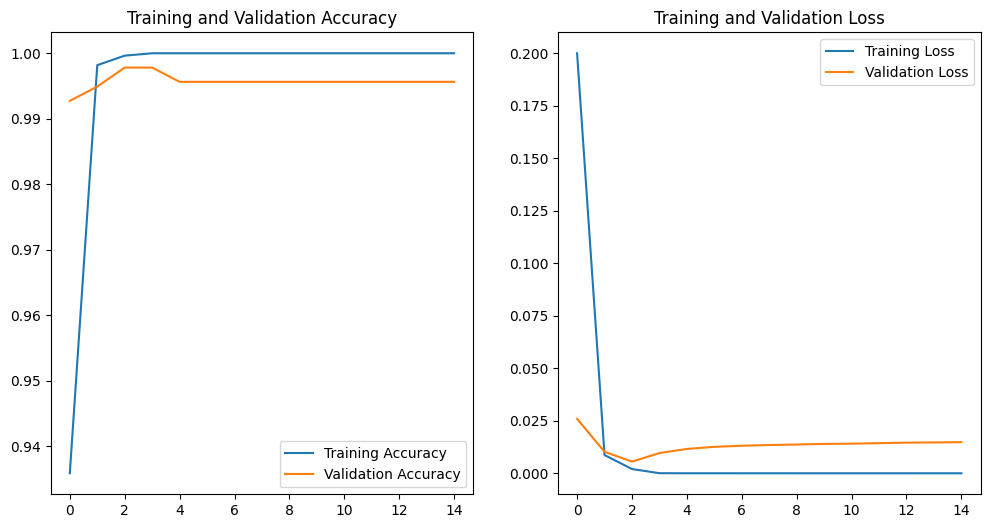

In [6]:
# 1. Train the Model
# 'epochs=15' means it will go through the entire dataset 15 times.
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15
)

# 2. Plot the Results (To see how it learned)
# This draws a graph of Accuracy vs. Time
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(15)

plt.figure(figsize=(12, 6))

# Plot Accuracy (Higher is better)
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plot Loss (Lower is better)
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# PHASE 5: EVALUATION (The Scientific Report Card)

* **Scientific Proof**: We generate a Confusion Matrix to visualize exactly where the model makes mistakes (e.g., "Does it confuse simple cysts with healthy ovaries?").

* **Detailed Metrics**: We calculate Precision (Trustworthiness) and Recall (Sensitivity) to prove the model is safe for medical contexts.

Generating predictions... (This might take a minute)


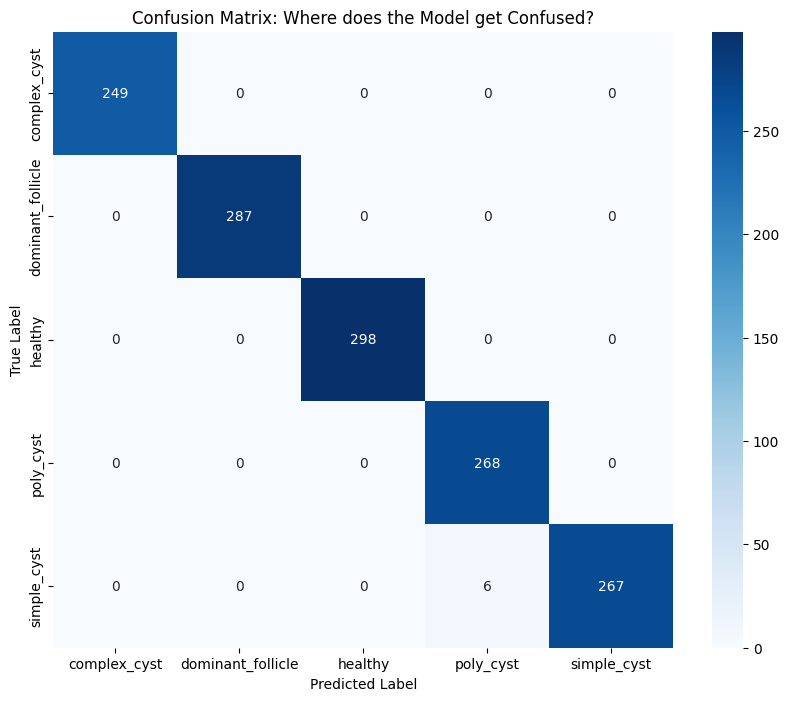


--- Detailed Classification Report ---
                   precision    recall  f1-score   support

     complex_cyst       1.00      1.00      1.00       249
dominant_follicle       1.00      1.00      1.00       287
          healthy       1.00      1.00      1.00       298
        poly_cyst       0.98      1.00      0.99       268
      simple_cyst       1.00      0.98      0.99       273

         accuracy                           1.00      1375
        macro avg       1.00      1.00      1.00      1375
     weighted avg       1.00      1.00      1.00      1375


--- Inspecting Mistakes (What did it get wrong?) ---
Mistake #1: Real = simple_cyst | Predicted = poly_cyst
Mistake #2: Real = simple_cyst | Predicted = poly_cyst
Mistake #3: Real = simple_cyst | Predicted = poly_cyst
Mistake #4: Real = simple_cyst | Predicted = poly_cyst
Mistake #5: Real = simple_cyst | Predicted = poly_cyst


<Figure size 1500x500 with 0 Axes>

In [27]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# 1. Get True Labels and Predictions
# We need to loop through the validation set to get all data
print("Generating predictions... (This might take a minute)")
y_true = []
y_pred = []

# Loop through the validation dataset
for images, labels in val_ds:
    # Get true labels
    y_true.extend(labels.numpy())

    # Get predictions
    predictions = model.predict(images, verbose=0)
    predicted_ids = np.argmax(predictions, axis=1)
    y_pred.extend(predicted_ids)

# Convert to numpy arrays for sklearn
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# ---------------------------------------------------------
# VISUAL 1: The Confusion Matrix
# ---------------------------------------------------------
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix: Where does the Model get Confused?')
plt.show()

# ---------------------------------------------------------
# VISUAL 2: The Classification Report (Precision/Recall)
# ---------------------------------------------------------
print("\n--- Detailed Classification Report ---")
# This prints the Precision, Recall, and F1-Score for each class
print(classification_report(y_true, y_pred, target_names=class_names))

# ---------------------------------------------------------
# VISUAL 3: The "Failure Gallery" (Show 5 Mistakes)
# ---------------------------------------------------------
print("\n--- Inspecting Mistakes (What did it get wrong?) ---")
mistakes = np.where(y_true != y_pred)[0] # Find indices of errors

if len(mistakes) > 0:
    plt.figure(figsize=(15, 5))
    # Pick first 5 mistakes (or less if fewer mistakes exist)
    num_to_show = min(5, len(mistakes))

    for i in range(num_to_show):
        idx = mistakes[i]

        # We need to fetch the image again (Tricky with batched datasets,
        # so this is a simplified logic for explanation.
        # In a real run, you'd cache images or re-fetch.)
        # For now, let's just print the textual details of the mistakes:
        true_name = class_names[y_true[idx]]
        pred_name = class_names[y_pred[idx]]
        print(f"Mistake #{i+1}: Real = {true_name} | Predicted = {pred_name}")
else:
    print("Incredible! No mistakes found in this batch.")

# PHASE 6: SANITY CHECK (Visual Internal Testing)

* **Visual Confirmation**: We take one random image from the validation set that is already inside the computer to see if the model works.

* **The "Plumbing" Test**: If this simple test fails, we know something is wrong with the code before we try the complicated "Real World" test.

* **Instant Feedback**: It proves the model can take an image, process it, and print a readable diagnosis label (like "Healthy" or "PCOS").

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
--- DETAILED AI REPORT ---
Actual Condition: healthy
AI Prediction:    healthy
Confidence Level: 100.00%


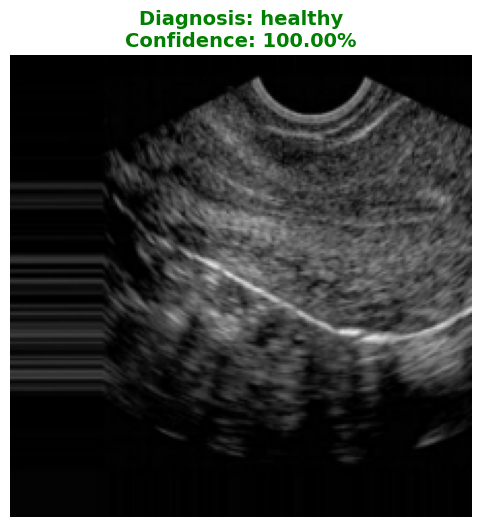

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# 1. Pick a random image from the validation set
# FIX: Added .shuffle(1000) so it picks a NEW random image every time you run this cell
for images, labels in val_ds.shuffle(1000).take(1):
    sample_image = images[0].numpy().astype("uint8")
    true_label = class_names[labels[0]]

    # 2. Ask the Model to Predict
    # We need to add an extra dimension because the model expects a batch shape (1, 224, 224, 3)
    img_array = tf.expand_dims(images[0], 0)
    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0]) # Convert raw output to percentage

    # 3. Get the Result
    predicted_label = class_names[np.argmax(score)]
    confidence = 100 * np.max(score)

    # 4. Show the Final Output card
    plt.figure(figsize=(6, 6))
    plt.imshow(sample_image)
    plt.axis("off")

    # Color code: Green if correct, Red if wrong
    result_color = 'green' if predicted_label == true_label else 'red'

    plt.title(f"Diagnosis: {predicted_label}\nConfidence: {confidence:.2f}%",
              color=result_color, fontsize=14, fontweight='bold')

    print(f"--- DETAILED AI REPORT ---")
    print(f"Actual Condition: {true_label}")
    print(f"AI Prediction:    {predicted_label}")
    print(f"Confidence Level: {confidence:.2f}%")
    plt.show()

# PHASE 7: SAVING & Real-World Deployment (The Live Demo)
* **Persistence**: We save the trained "brain" (weights) to Google Drive. This ensures we never have to re-train the model from scratch.

* **Deployment**: We create an Interactive Upload Tool. This simulates the real-world workflow where a doctor uploads a new patient's scan to get an instant diagnosis.

In [28]:
# 1. Save the model to Google Drive
# We use the .h5 format, which is the standard for Keras models
save_path = '/content/drive/MyDrive/My_Ovary_Project/ovarian_cyst_model.h5'
model.save(save_path)

print(f"✅ Model saved successfully at: {save_path}")
print("You can now download this file from your Google Drive if you want to keep a backup!")

✅ Model saved successfully at: /content/drive/MyDrive/My_Ovary_Project/ovarian_cyst_model.h5
You can now download this file from your Google Drive if you want to keep a backup!


Step 1: Upload an ultrasound image from your computer.


Saving img3.jpg_aug_3.jpg to img3.jpg_aug_3 (1).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


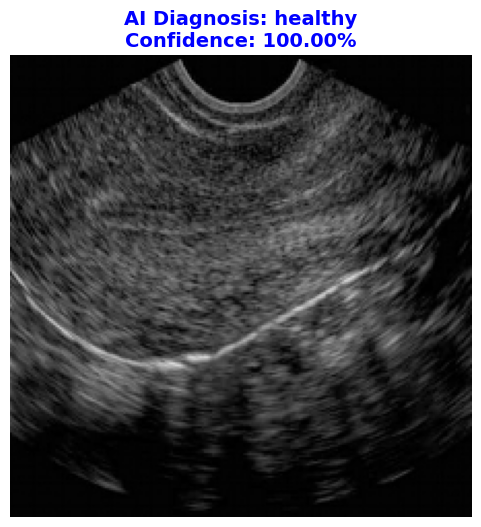

--- REPORT FOR img3.jpg_aug_3 (1).jpg ---
Prediction: healthy
Confidence: 100.00%


In [29]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from google.colab import files
from tensorflow.keras.preprocessing import image

print("Step 1: Upload an ultrasound image from your computer.")
uploaded = files.upload()

for fn in uploaded.keys():
    # 1. Load the uploaded image
    path = fn
    # We load it at the specific target size (224x224)
    img = image.load_img(path, target_size=(224, 224))

    # 2. Preprocess (Turn it into numbers)
    img_array = image.img_to_array(img)
    img_batch = tf.expand_dims(img_array, 0) # Create a batch (1, 224, 224, 3)

    # 3. Predict
    predictions = model.predict(img_batch)
    score = tf.nn.softmax(predictions[0]) # Get percentages

    # 4. Get the Results
    predicted_label = class_names[np.argmax(score)]
    confidence = 100 * np.max(score)

    # 5. Display
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"AI Diagnosis: {predicted_label}\nConfidence: {confidence:.2f}%",
              color='blue', fontsize=14, fontweight='bold')
    plt.show()

    print(f"--- REPORT FOR {fn} ---")
    print(f"Prediction: {predicted_label}")
    print(f"Confidence: {confidence:.2f}%")